## In this notebook we georeference GEDI and ICESat-2 data


## Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore") # suppress warnings

In [2]:
import os
import sys
import h5py
import pyproj
import shapely
import warnings
import datetime 
import numpy as np
import pandas as pd
import geoviews as gv
import holoviews as hv
import geopandas as gpd
import contextily as ctx  # For adding a basemap
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from shapely.geometry import Point, box
from geoviews import opts, tile_sources as gvts
from sliderule import sliderule, icesat2, earthdata
from shapely.errors import ShapelyDeprecationWarning

plt.style.use("~/geoscience/carbon_estimation/MNRAS.mplstyle")
%matplotlib inline

In [3]:
function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
sys.path.append(function_path)

# Check the default PROJ data directory
print(pyproj.datadir.get_data_dir())
# # If needed, explicitly set the PROJ data directory before running the script. This might not be necessary for everyone
# pyproj.datadir.set_data_dir("/bsuhome/tnde/miniconda3/envs/veg_height/share/proj") # This manually set the PROJ data directory if the correct grid transformation does not appear.

/bsuscratch/tnde/miniforge3/envs/veg_height/share/proj


## Loading GEDI Data

### Twin Falls Data

In [4]:
# from helper_functions import load_gedi_data
# gedi_dir_l2a = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi02_A_002_twinfalls/output/"

# # Load GEDI data with acquisition date
# merged_gedi_gdf_l2a = load_gedi_data(gedi_dir_l2a, 'GEDI02_A')

# print("L2A length:", len(merged_gedi_gdf_l2a))

In [5]:
# merged_gedi_gdf_l2a_2 = merged_gedi_gdf_l2a[["Easting", "Northing", "elevation_NAVD88_gedi_from_crs", "rh_100", "elevation"]]
# merged_gedi_gdf_l2a_2 = merged_gedi_gdf_l2a_2.rename(columns={"elevation": "Elevation_default", "elevation_NAVD88_gedi_from_crs": "Elevation"})
# merged_gedi_gdf_l2a_2 = merged_gedi_gdf_l2a_2[merged_gedi_gdf_l2a_2["Elevation"]>1000]
# merged_gedi_gdf_l2a_2

In [6]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/gedi_twinfalls.csv" #set name of the output #set name of the output
# merged_gedi_gdf_l2a_2.to_csv(cvs_name)

In [7]:
# merged_gedi_gdf_l2a_3 = merged_gedi_gdf_l2a_2.copy()
# merged_gedi_gdf_l2a_3["Elevation"] = merged_gedi_gdf_l2a_3["Elevation"] + merged_gedi_gdf_l2a_3["rh_100"]
# # merged_gedi_gdf_l2a_3 = merged_gedi_gdf_l2a_3[merged_gedi_gdf_l2a_3["rh_100"]>0] # for non-ground only footprints. Comment this for non-ground points.
# # cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/gedi_twinfalls_non_ground_only.csv" #set name of the output #set name of the output
# # merged_gedi_gdf_l2a_3.to_csv(cvs_name)
# merged_gedi_gdf_l2a_3

### RCEW Data

In [8]:
from helper_functions import load_gedi_data
gedi_dir_l1b = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi01_B_002/output/"
gedi_dir_l2a = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi02_A_002/output/"
gedi_dir_l2b = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/gedi02_B_002/output/"

# Load GEDI data with acquisition date
merged_gedi_gdf_l1b = load_gedi_data(gedi_dir_l1b, 'GEDI01_B')
merged_gedi_gdf_l2a = load_gedi_data(gedi_dir_l2a, 'GEDI02_A')
merged_gedi_gdf_l2b = load_gedi_data(gedi_dir_l2b, 'GEDI02_B')

print("L1B length:", len(merged_gedi_gdf_l1b))
print("L2A length:", len(merged_gedi_gdf_l2a))
print("L2B length:", len(merged_gedi_gdf_l2b))

L1B length: 23303
L2A length: 23265
L2B length: 23303


In [9]:
merged_gedi_gdf_l1b.crs

<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [10]:
# Check if the data has a Z column in its geometry; if False, then we will use the ground elevation as the Z axis/column.
has_z = merged_gedi_gdf_l1b.geometry.has_z.any()
print("Does the GeoDataFrame have a Z column in its geometry?", has_z)

Does the GeoDataFrame have a Z column in its geometry? False


In [11]:
display(merged_gedi_gdf_l1b[["elevation", "elevation_NAVD88_gedi_from_crs"]].head())
diff = merged_gedi_gdf_l1b["elevation_NAVD88_gedi_from_crs"] - merged_gedi_gdf_l1b["elevation"]
display("Difference:", diff)
display("Description of the difference:", diff.describe())

elevation  elevation_NAVD88_gedi_from_crs
0  1879.3390                     1896.689532
1  1874.0612                     1891.411996
2  1857.5990                     1874.950036
3  1869.7548                     1887.106053
4  1869.7548                     1887.106261

'Difference:'

0        17.350532
1        17.350796
2        17.351036
3        17.351253
4        17.351461
           ...    
78766    17.444483
78767    17.445840
78768    17.447168
78769    17.449812
78770    17.449738
Length: 23303, dtype: float64

'Description of the difference:'

count    23303.000000
mean        17.230157
std          0.178787
min         16.836043
25%         17.086572
50%         17.268431
75%         17.382781
max         17.491932
dtype: float64

## Merging GEDI Data Sets
### Method 1: `merge` method

Here, we merge the three data sets; L1B, L2A, and L2B, using their short numbers.

We can use `merge()` since `shot_number` values perfectly match across data sets.

In [12]:
# Search for common columns in the three data sets. These columns will give us the basis/critterion for merging the data sets.
common_cols = set(merged_gedi_gdf_l1b.columns)&set(merged_gedi_gdf_l2a.columns)&set(merged_gedi_gdf_l2b.columns)
common_cols = list(common_cols) # Convert back to list
common_cols

['elevation_NAVD88_gedi_from_pipe',
 'Longitude',
 'date',
 'acquisition_date',
 'Latitude',
 'Northing',
 'BEAM',
 'index',
 'elevation_NAVD88_gedi_from_crs',
 'elevation',
 'Easting',
 'geometry']

In [13]:
print(len(merged_gedi_gdf_l1b["shot_number_x"].unique()), 
     len(merged_gedi_gdf_l2a["shot_number"].unique()),
     len(merged_gedi_gdf_l2b["shot_number"].unique()))

23303 23265 23303


In [14]:
from helper_functions import merge_gedi_data
data_list = [merged_gedi_gdf_l1b, merged_gedi_gdf_l2a, merged_gedi_gdf_l2b]
col_list = ["shot_number_x", "shot_number", "shot_number"]
surfix_list = ["_l1b", "_l2a", "_l2b"]
method1 = "merge"

final_merged_gdf = merge_gedi_data(data_list, col_list, surfix_list, method1)
print(f"Final merged dataset size: {len(final_merged_gdf)}")
# Display the first few rows
display(final_merged_gdf.head()) 
display(final_merged_gdf[["Latitude_l1b", "Latitude_l2a", "Latitude", "Longitude_l1b", "Longitude_l2a", "Longitude"]])

Final merged dataset size: 23262


BEAM_l2a        shot_number  Latitude_l2a  Longitude_l2a  index_l2a  \
0  BEAM1011  34511100200281473     43.309238    -116.831206     113648   
1  BEAM1011  34511100200281474     43.309520    -116.830618     113649   
2  BEAM1011  34511100200281475     43.309801    -116.830030     113650   
3  BEAM1011  34511100200281476     43.310082    -116.829441     113651   
4  BEAM1011  34511100200281477     43.310364    -116.828854     113652   

   degrade_flag    delta_time  digital_elevation_model  \
0             0  4.908651e+07                1798.0383   
1             0  4.908651e+07                1798.0383   
2             0  4.908651e+07                1797.0074   
3             0  4.908651e+07                1795.8794   
4             0  4.908651e+07                1795.8794   

   digital_elevation_model_srtm  elev_lowestmode  ...  stale_return_flag_l2b  \
0                     1799.5100        1799.3198  ...                      0   
1                     1799.5100        1801.7000  ...                      0   
2                     1798.5099        1798.3579  ...                      0   
3                     1797.5099        1796.2415  ...                      0   
4                     1797.5098        1796.0858  ...                      0   

   surface_flag_l2b                        geometry  acquisition_date  \
0                 1  POINT (513688.965 4795169.966)     2019204022957   
1                 1   POINT (513736.57 4795201.316)     2019204022957   
2                 1  POINT (513784.205 4795232.651)     2019204022957   
3                 1  POINT (513831.832 4795263.988)     2019204022957   
4                 1  POINT (513879.447 4795295.327)     2019204022957   

                 date        Easting      Northing  elevation  \
0 2019-07-23 02:29:57  513688.964915  4.795170e+06  1798.0383   
1 2019-07-23 02:29:57  513736.570004  4.795201e+06  1798.0383   
2 2019-07-23 02:29:57  513784.205063  4.795233e+06  1797.0074   
3 2019-07-23 02:29:57  513831.832065  4.795264e+06  1795.8794   
4 2019-07-23 02:29:57  513879.447137  4.795295e+06  1795.8794   

   elevation_NAVD88_gedi_from_pipe  elevation_NAVD88_gedi_from_crs  
0                      1814.884409                     1815.427281  
1                      1814.885509                     1815.428389  
2                      1813.855711                     1814.398598  
3                      1812.728813                     1813.271707  
4                      1812.729917                     1813.272818  

[5 rows x 283 columns]

Latitude_l1b  Latitude_l2a   Latitude  Longitude_l1b  Longitude_l2a  \
0         43.309240     43.309238  43.309238    -116.831209    -116.831206   
1         43.309521     43.309520  43.309520    -116.830621    -116.830618   
2         43.309802     43.309801  43.309801    -116.830033    -116.830030   
3         43.310084     43.310082  43.310082    -116.829445    -116.829441   
4         43.310365     43.310364  43.310364    -116.828857    -116.828854   
...             ...           ...        ...            ...            ...   
23260     43.219620     43.219620  43.219620    -116.688407    -116.688407   
23261     43.221042     43.221071  43.221071    -116.690981    -116.691036   
23262     43.220763     43.220791  43.220791    -116.690398    -116.690453   
23263     43.220485     43.220513  43.220513    -116.689817    -116.689872   
23264     43.220205     43.220234  43.220234    -116.689232    -116.689288   

        Longitude  
0     -116.831206  
1     -116.830618  
2     -116.830030  
3     -116.829441  
4     -116.828854  
...           ...  
23260 -116.688407  
23261 -116.691036  
23262 -116.690453  
23263 -116.689872  
23264 -116.689288  

[23262 rows x 6 columns]

In [15]:
# Count missing values per column
missing_values = final_merged_gdf.isna().sum()
print(missing_values[missing_values > 0])  # Display only columns with missing values

# Count rows where L2A or L2B data is missing
missing_l1b = final_merged_gdf["shot_number_x"].isna().sum()  # From L1B
missing_l2a = final_merged_gdf["shot_number"].isna().sum()  # From L2A
missing_l2b = final_merged_gdf["geolocation_shot_number_l2b"].isna().sum()  # From L2B

print(f"Missing L1B records: {missing_l1b}")
print(f"Missing L2A records: {missing_l2a}")
print(f"Missing L2B records: {missing_l2b}")

# Show rows where data is missing
pd.set_option("display.max_columns", None)
missing_data = final_merged_gdf[final_merged_gdf.isna().any(axis=1)]
display(missing_data.head())

Series([], dtype: int64)
Missing L1B records: 0
Missing L2A records: 0
Missing L2B records: 0


Empty GeoDataFrame
Columns: [BEAM_l2a, shot_number, Latitude_l2a, Longitude_l2a, index_l2a, degrade_flag, delta_time, digital_elevation_model, digital_elevation_model_srtm, elev_lowestmode, elevation_bias_flag, num_detectedmodes, quality_flag, rh_0, rh_1, rh_2, rh_3, rh_4, rh_5, rh_6, rh_7, rh_8, rh_9, rh_10, rh_11, rh_12, rh_13, rh_14, rh_15, rh_16, rh_17, rh_18, rh_19, rh_20, rh_21, rh_22, rh_23, rh_24, rh_25, rh_26, rh_27, rh_28, rh_29, rh_30, rh_31, rh_32, rh_33, rh_34, rh_35, rh_36, rh_37, rh_38, rh_39, rh_40, rh_41, rh_42, rh_43, rh_44, rh_45, rh_46, rh_47, rh_48, rh_49, rh_50, rh_51, rh_52, rh_53, rh_54, rh_55, rh_56, rh_57, rh_58, rh_59, rh_60, rh_61, rh_62, rh_63, rh_64, rh_65, rh_66, rh_67, rh_68, rh_69, rh_70, rh_71, rh_72, rh_73, rh_74, rh_75, rh_76, rh_77, rh_78, rh_79, rh_80, rh_81, rh_82, rh_83, rh_84, rh_85, rh_86, ...]
Index: []

In [16]:
# Check if some of the short numbers in the merged data set are different
check = final_merged_gdf[final_merged_gdf["shot_number_x"] != final_merged_gdf["shot_number"]][["shot_number_x", "shot_number", "geolocation_shot_number_l2b"]]
check

Empty DataFrame
Columns: [shot_number_x, shot_number, geolocation_shot_number_l2b]
Index: []

### ML Data

In [19]:
# print(len(final_merged_gdf[final_merged_gdf["stale_return_flag"] != 0]["stale_return_flag"]))
# print(len(final_merged_gdf[final_merged_gdf["degrade_flag"] != 0]["degrade_flag"]))

# final_merged_gdf = final_merged_gdf[final_merged_gdf["stale_return_flag"] == 0]
# final_merged_gdf = final_merged_gdf[final_merged_gdf["degrade_flag"] == 0]

# print(len(final_merged_gdf[final_merged_gdf["stale_return_flag"] != 0]["stale_return_flag"]))
# print(len(final_merged_gdf[final_merged_gdf["degrade_flag"] != 0]["degrade_flag"]))
# print(len(final_merged_gdf))


In [20]:
# print(len(merged_gedi_gdf_l1b[merged_gedi_gdf_l1b["stale_return_flag"] != 0]))
# print(len(merged_gedi_gdf_l1b[merged_gedi_gdf_l1b["geolocation_degrade"] != 0]))


In [21]:
# print(len(merged_gedi_gdf_l2b[merged_gedi_gdf_l2b["stale_return_flag"] != 0]))
# print(len(merged_gedi_gdf_l2b[merged_gedi_gdf_l2b["geolocation_degrade_flag"] != 0]))

In [22]:
# for col in merged_gedi_gdf_l2b.columns:
#     print(col)

In [23]:
# cols = ["date", "shot_number", "BEAM_l2a", "Latitude_l2a", "Longitude_l2a", 
#         "quality_flag", "num_detectedmodes", "rh_80", "rh_85", "rh_90", "rh_95", "rh_98", 
#         "rh_99", "rh_100", "sensitivity", "solar_elevation", "geometry_l2a", 
#         "Easting_l2a", "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", 
#         "GEDI02_A_slope_ratio_utm", "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run", 
#         "rx_sample_count", "cover_z_10", "cover_z_15", "cover_z_20", "cover_z_25", 
#         "cover_z_27", "cover_z_28", "cover_z_29", "fhd_normal", "pai_z_10", "pai_z_15", 
#         "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pai_z_29", "pavd_z_10", 
#         "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "pavd_z_29", "rh100"]#, "degrade_flag", "stale_return_flag"]

In [24]:
# ml_data = final_merged_gdf[cols]
# ml_data.head()

In [25]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml2.csv" #set name of the output #set name of the output
# ml_data.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# ml_data.to_file(outName, driver="GeoJSON")  # Export to GeoJSON


#########################
#########################
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/gedi_ml_detection_threshold.csv" #set name of the output #set name of the output
# ml_data.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# ml_data.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

In [ ]:
# # List of RH metrics to plot
# rh_metrics = ["rh_100", "rh_90", "rh_80"]

# plt.figure(figsize=(10, 6))

# # Plot each RH metric
# for rh in rh_metrics:
#     print(f"{rh}: length = {len(ml_data[rh])}, min = {np.min(ml_data[rh])}")
#     plt.hist(ml_data[rh], bins=50, alpha=0.6, label=f"{rh}")#, edgecolor="black")

# # vertical threshold line
# plt.axvline(x=0.5, color="r", linestyle='--', label="0.5m Threshold")

# plt.xlabel("Vegetation Height [m]")
# plt.ylabel("Count")
# # plt.title("Distribution of GEDI Vegetation Heights (RH Metrics)")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### Method 2: `sjoin` method. 
Here we use spatial join instead of `merge`. Assuming that `shot_number_x` doesn’t perfectly match `shot_number`, you can spatially join merged_gedi_gdf_l1b with merged_gedi_gdf_l2a and merged_gedi_gdf_l2b based on geometry (lat/lon or northing/easting).

We can use `sjoin_nearest()` if shot numbers do not match but geometries (lat/lon or northing/easting) are close.

**Note:** In our specific case, both methods are equivalent. They work them same way. The results are exactly the same. This is beause the shot numbers do match and the geometries (lat/lon or northing/easting) are close. Hence, both methods work equally the same way.

**Optional:**
We can use the steps below to check the accuracy of our spatial join. 

1. Inspect distance values
    - Print summary statistics of distances.
    - Identify the maximum, mean, and standard deviation of distances.
    - Check for unusually high distances that may indicate incorrect joins.

2. Set a distance threshold if necessary (max allowed distance). In our specific case this isn't really necessary, because the default threshold is already working fine.
    - Define a reasonable max_distance based on the expected spatial accuracy.
    - Re-run sjoin_nearest with this threshold.

3. Visual Inspection (Optional)
    - Plot points before and after joining to see if they align correctly.

In [26]:
# method2 = "sjoin"
# final_spatial_gdf, final_spatial_gdf_filtered = merge_gedi_data(data_list, col_list, surfix_list, method2)
# print("Unfiltered data set length", len(final_spatial_gdf))
# print("Filtered data set length", len(final_spatial_gdf_filtered))

# # Display the merged dataset
# pd.set_option("display.max_columns", None)  # number of columns to show in output. `None` means show all columns.
# display(final_spatial_gdf.head())
# display(final_spatial_gdf[["Latitude__l1b", "Latitude__l2a", "Latitude", "Longitude__l1b", "Longitude__l2a", "Longitude"]].head())
# display(final_spatial_gdf[final_spatial_gdf["distance_l1b"] == 0][["distance_l1b", "distance_l2b"]])

# # Check distance summary statistics
# print("Distance to L1B summary:\n", final_spatial_gdf["distance_l1b"].describe())
# print("\nDistance to L2B summary:\n", final_spatial_gdf["distance_l2b"].describe())

# print(f"\nFiltered dataset size: {len(final_spatial_gdf_filtered)} (after removing large distances)")
# # check distance summary statistics again
# print("Distance to L1B summary:\n", final_spatial_gdf_filtered["distance_l1b"].describe())
# print("\nDistance to L2B summary:\n", final_spatial_gdf_filtered["distance_l2b"].describe())

# # # Save to a CSV or GeoJSON for further inspection
# # final_spatial_gdf.to_csv("spatially_merged_gedi.csv", index=False)
# # final_spatial_gdf.to_file("spatially_merged_gedi.geojson", driver="GeoJSON")

In [27]:
# # Count missing values per column
# missing_values = final_spatial_gdf.isna().sum()
# print(missing_values[missing_values > 0])  # Display only columns with missing values

# # Count rows where L2A or L2B data is missing
# missing_l1b = final_spatial_gdf["shot_number_x"].isna().sum()  # From L1B
# missing_l2a = final_spatial_gdf["shot_number__merged"].isna().sum()  # From L2A
# missing_l2b = final_spatial_gdf["shot_number__l2b"].isna().sum()  # From L2B

# print(f"Missing L1B records: {missing_l1b}")
# print(f"Missing L2A records: {missing_l2a}")
# print(f"Missing L2B records: {missing_l2b}")

# # Show rows where data is missing
# missing_data = final_spatial_gdf[final_spatial_gdf.isna().any(axis=1)]
# display(missing_data.head())

In [28]:
# final_spatial_gdf[final_spatial_gdf["distance_l1b"]>20][["shot_number__merged", "shot_number_x", "shot_number__l2b", "distance_l1b"]]

### Plot the Merged Data

In [40]:
# Projected CRS
projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
# Specify region of interest shapefile
shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"
shapefile = gpd.read_file(shp)
shapefile.crs is None
shapefile = shapefile.to_crs(projected_crs)
# shapefile.to_file('/bsuhome/tnde/geoscience/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson', driver='GeoJSON')

# Specify region of interest from geojson
poly_fn = '/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.geojson'
pregion = gpd.read_file(poly_fn)
pregion = pregion.to_crs(projected_crs)
region = sliderule.toregion(poly_fn)["poly"] # symplify 

# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

In [30]:
# print(ctx.providers.keys())

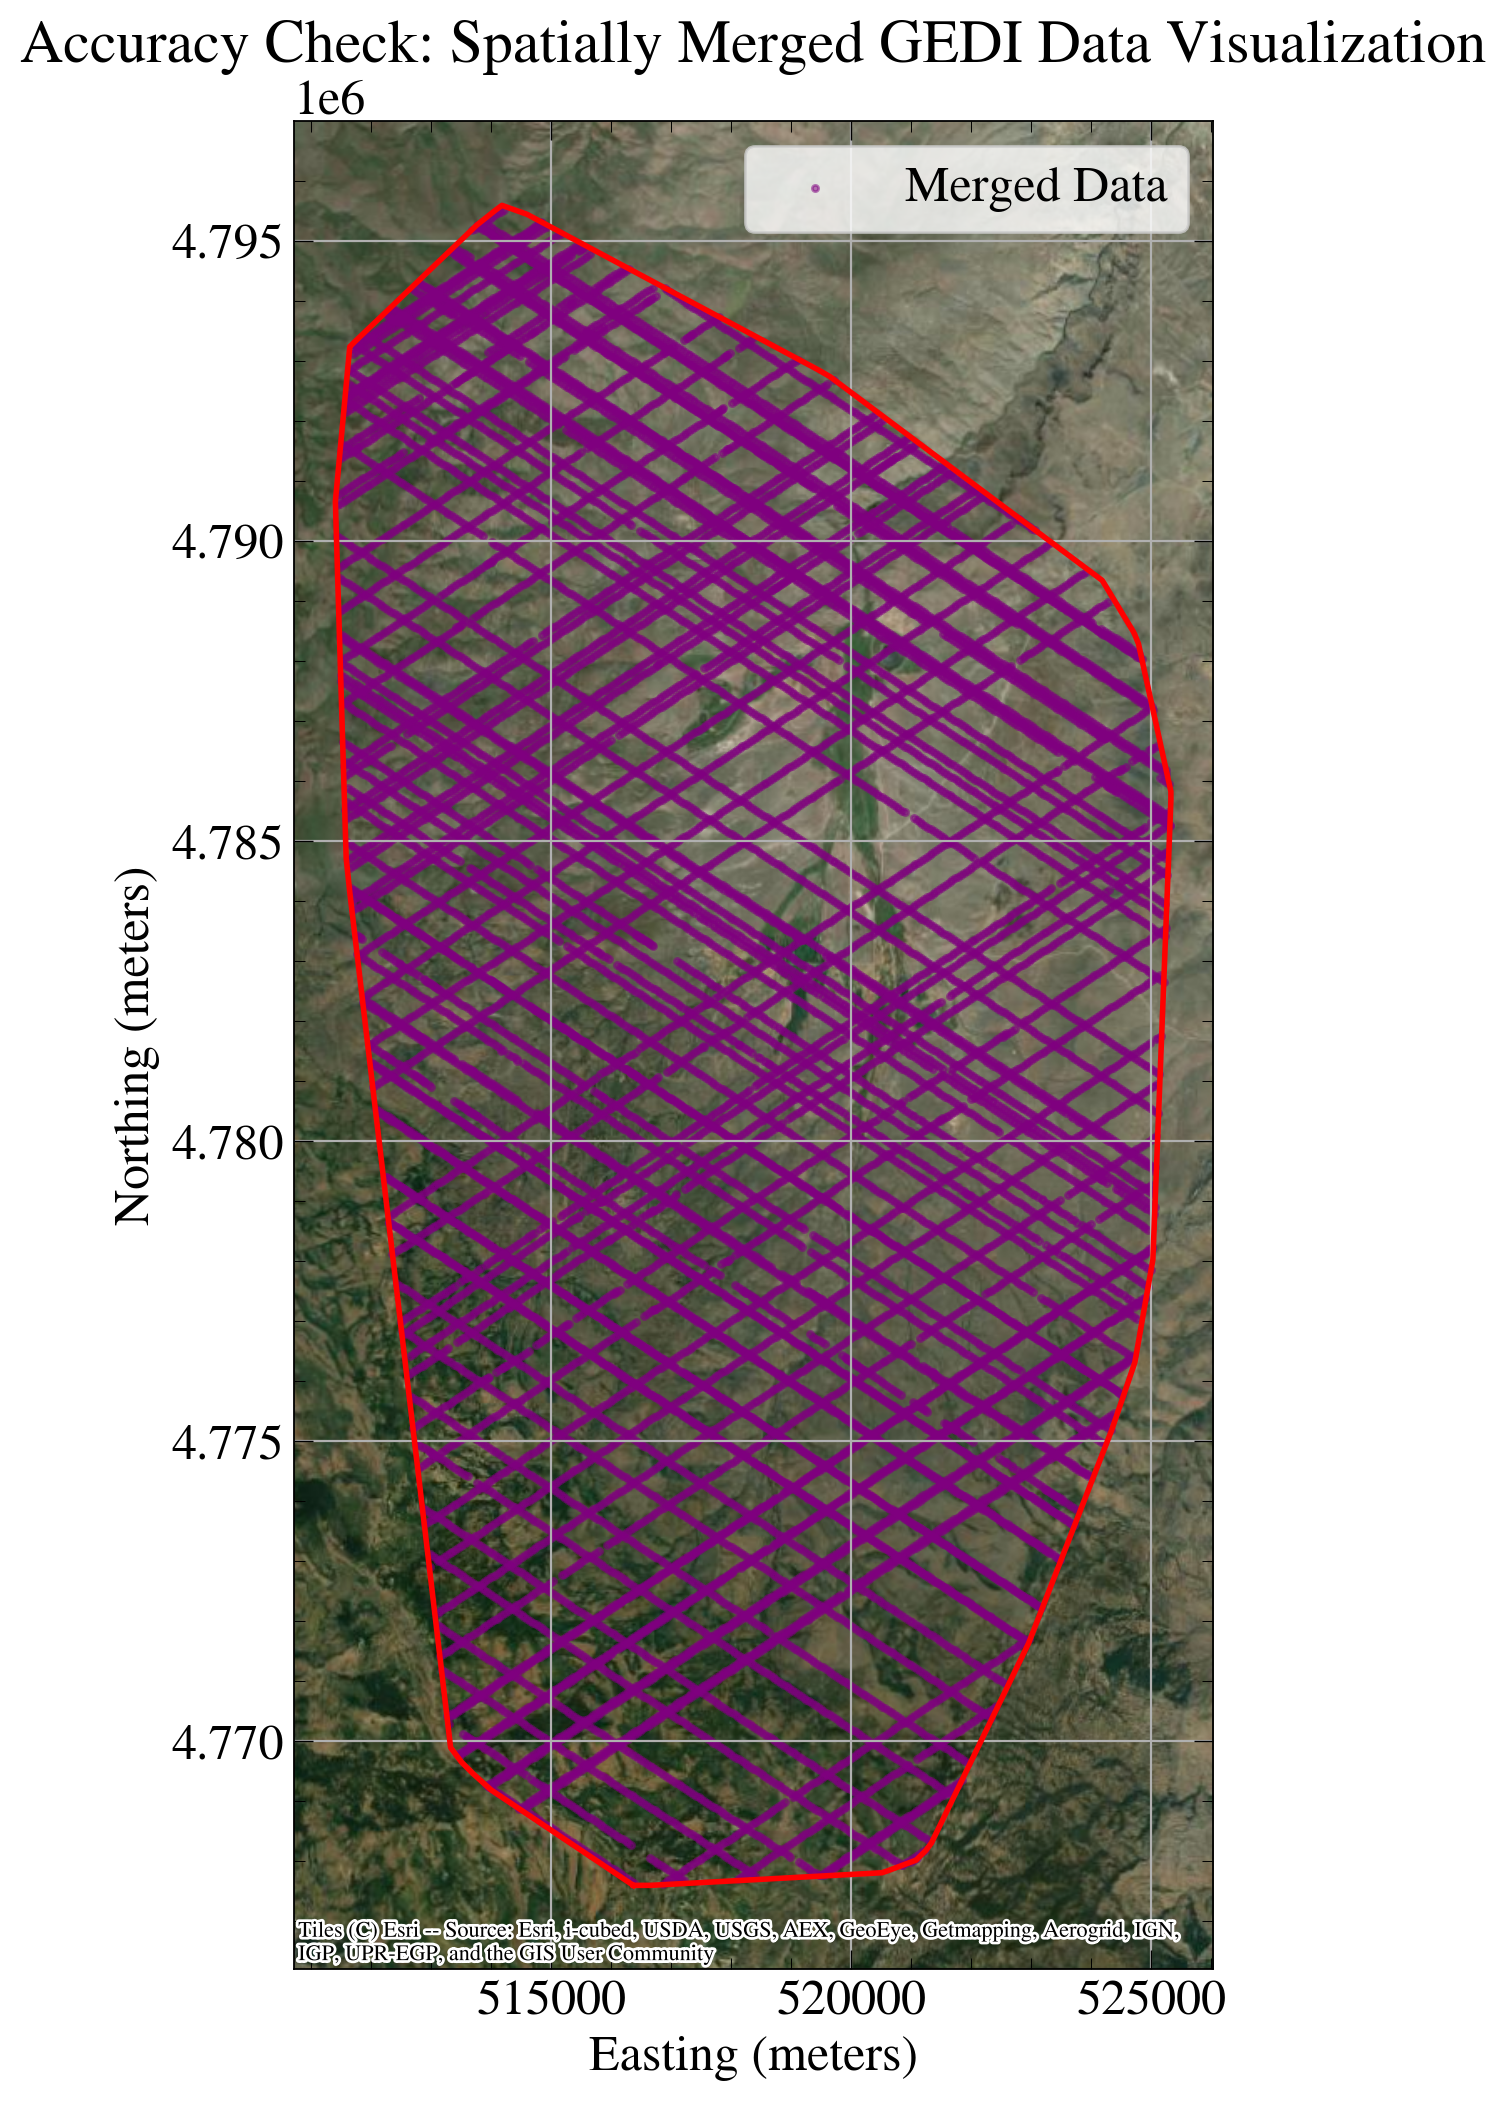

In [31]:
# Plot the merged dataset
fig, ax = plt.subplots(figsize=(10, 12))

# Plot different datasets with different colors
final_merged_gdf.plot(ax=ax, color="purple", markersize=5, alpha=0.5, label="Merged Data")
ax.plot(region_lon, region_lat, linewidth=2, color='r')

# Add a basemap (Optional)
ctx.add_basemap(ax, crs=final_merged_gdf.crs, source=ctx.providers.Esri.WorldImagery)
# ctx.add_basemap(ax, crs=final_spatial_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik)
# ctx.add_basemap(ax, crs=final_spatial_gdf.crs, source=ctx.providers.CartoDB.Positron)

# Formatting the map
plt.legend()
plt.title("Accuracy Check: Spatially Merged GEDI Data Visualization")
plt.xlabel("Easting (meters)")
plt.ylabel("Northing (meters)")
plt.show()

## Loading ICESat-2 Data

### The ATL08 Product

In [2]:
# Twin Falls

# from helper_functions import load_icesat2_data
# # Projected CRS
# projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
# icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/"
# atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_twinfalls.geojson"}'
# atl08

In [34]:
# %%time
# icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = True)
# icesat2_gdf_atl08 = icesat2_gdf_atl08.iloc[1:].reset_index(drop=True) # keep everything except the first row
# print(icesat2_gdf_atl08.crs, "\n")

# icesat2_gdf_atl08_2 = icesat2_gdf_atl08[["Easting", "Northing", "elevation_NAVD88_icesat2_from_crs", "h_te_median", "h_mean_canopy"]]
# icesat2_gdf_atl08_2 = icesat2_gdf_atl08_2.rename(columns={"h_te_median": "Elevation_default", "elevation_NAVD88_icesat2_from_crs": "Elevation"})
# icesat2_gdf_atl08_2 = icesat2_gdf_atl08_2[icesat2_gdf_atl08_2["Elevation"]>1000]
# icesat2_gdf_atl08_2

In [36]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/icesat2_twinfalls.csv" #set name of the output #set name of the output
# icesat2_gdf_atl08_2.to_csv(cvs_name)

# icesat2_gdf_atl08_3 = icesat2_gdf_atl08_2.copy()
# icesat2_gdf_atl08_3["Elevation"] = icesat2_gdf_atl08_3["Elevation"] + icesat2_gdf_atl08_3["h_mean_canopy"]
# # icesat2_gdf_atl08_3 = icesat2_gdf_atl08_3[icesat2_gdf_atl08_3["h_mean_canopy"]>0] # for non-ground only footprints. Comment this for non-ground points.
# # cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/cloudcompare/icesat2_twinfalls_non_ground_only.csv" #set name of the output #set name of the output
# icesat2_gdf_atl08_3.to_csv(cvs_name)
# icesat2_gdf_atl08_3

In [28]:
# RCEW
from helper_functions import load_icesat2_data
# Projected CRS
projected_crs = "epsg:6340"  # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/"
atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new_final.geojson"}'
atl08

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl08_all_new_final.geojson'

In [29]:
%%time
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = True)
icesat2_gdf_atl08 = icesat2_gdf_atl08.iloc[1:].reset_index(drop=True) # keep everything except the first row
print(icesat2_gdf_atl08.crs, "\n")

Columns: Index(['time', 'x_atc', 'h_min_canopy', 'h_te_median', 'gt', 'spot', 'rgt',
       'gnd_ph_count', 'h_mean_canopy', 'h_canopy', 'h_max_canopy',
       'snowcover', 'ph_count', 'canopy_h_metrics', 'solar_elevation_x',
       'segment_id', 'veg_ph_count', 'landcover', 'extent_id',
       'canopy_openness', 'cycle', 'num_bins', 'binsize', 'waveform',
       'pce_mframe_cnt', 'solar_elevation_y', 'h_dif_ref', 'Longitude',
       'Latitude', 'Easting', 'Northing', 'elevation_NAVD88_icesat2_from_pipe',
       'elevation_NAVD88_icesat2_from_crs', 'Date', 'date', 'geometry'],
      dtype='object')
EPSG:6340 

CPU times: user 15.8 s, sys: 33.8 ms, total: 15.9 s
Wall time: 15.9 s


### ML Data

In [32]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/icesat2_ml_final.csv" #set name of the output #set name of the output
# icesat2_gdf_atl08.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# icesat2_gdf_atl08.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

In [33]:
# icesat2_gdf_atl08.shape
# # icesat2_gdf_atl08[["solar_elevation_x", "solar_elevation_y"]]

In [34]:
# elevation_NAVD88_gedi_from_crs
# final_merged_gdf[["elevation", "elevation_NAVD88_gedi_from_crs"]]

## Co-registration of GEDI and ICESat2 Data
### Approach: Nearest Neighbor Matching
#### Explanation of the Algorithm

1. **Time-first filtering**: First, we find all ICESat-2 points within the maximum time difference (120 days).
2. **Spatial Nearest Filtering**: Out of those time-matching points, we then find the spatially closest ICESat-2 point.
3. **Unique Matching**: Ensures no two GEDI points share the same ICESat-2 match.

**Summary**
1. Finds all ICESat-2 points within 180 days first
    * Uses `time_diffs = np.abs(gedi_date - icesat2_dates).dt.days`
    * Filters only those within `max_time_difference = 180`.

2. Then selects the nearest spatial neighbor
    * Builds a new KDTree only for time-matching points.
    * Finds the closest within `max_distance = k meters`. `k` is 25 meters in this case.

3. Ensures each ICESat-2 point is uniquely matched
    * If an ICESat-2 point is already assigned, it's skipped.

**Output**
1. Each GEDI point is matched to one ICESat-2 point that:
    * Has a time difference ≤ 180 days.
    * Is the closest spatial match among time-filtered points.
    * Is unique (no shared ICESat-2 matches).


In [35]:
# --- Make sure both GeoDataFrames are in the same metric CRS (UTM) ---
# If they already share the same .crs in meters, these .to_crs() are no-ops
utm_crs = final_merged_gdf.crs
if utm_crs is None:
    # If GEDI doesn't have a CRS, try inferring from ICESat-2
    utm_crs = icesat2_gdf_atl08.crs
if utm_crs is None:
    # As a last resort, estimate UTM from GEDI
    utm_crs = final_merged_gdf.estimate_utm_crs()

gedi_proj = final_merged_gdf.to_crs(utm_crs)
icesat2_proj = icesat2_gdf_atl08.to_crs(utm_crs).copy()

# # Ensure elevation column exists 
# icesat2_proj["elevation"] = icesat2_proj["elevation_NAVD88_icesat2_from_crs"]
# gedi_proj["elevation"] = gedi_proj["elevation_NAVD88_gedi_from_crs"]

# --- Coordinates in meters (Easting, Northing) for KDTree ---
gedi_coords = list(zip(gedi_proj.geometry.x, gedi_proj.geometry.y))
icesat2_coords = list(zip(icesat2_proj.geometry.x, icesat2_proj.geometry.y))

# --- Dates ---
gedi_dates = pd.to_datetime(gedi_proj['date'])
icesat2_dates = pd.to_datetime(icesat2_proj['date'])

# --- Thresholds ---
max_time_difference = 120         # days
max_distance = 25.0               # 25 meters

# --- Unique nearest-neighbor matching with time filter ---
unique_matches = {}

# store NN distances (meters) keyed by ICESat-2 index
match_distances_m = {}

for i, gedi_point in enumerate(gedi_coords):
    gedi_date = gedi_dates.iloc[i]

    # time filter (<= 180 days)
    time_diffs = np.abs(gedi_date - icesat2_dates).dt.days
    valid_time_idxs = np.where(time_diffs <= max_time_difference)[0]

    if valid_time_idxs.size > 0:
        # Build KDTree on time-filtered ICESat-2 subset (in meters)
        valid_icesat2_coords = [icesat2_coords[j] for j in valid_time_idxs]
        icesat2_tree_filtered = cKDTree(valid_icesat2_coords)

        # Query nearest neighbor with an upper bound of 25 m
        dist, nearest_idx = icesat2_tree_filtered.query(gedi_point, distance_upper_bound=max_distance)

        # cKDTree returns nearest_idx == len(valid_time_idxs) if none found within bound
        if nearest_idx < len(valid_time_idxs):
            selected_idx = valid_time_idxs[nearest_idx]
            if selected_idx not in unique_matches:
                unique_matches[selected_idx] = i
                # record the KDTree distance (meters) for this pair
                match_distances_m[selected_idx] = float(dist)

# --- Extract matched data and build the output DataFrame ---
unique_icesat2_indices = list(unique_matches.keys())
unique_gedi_indices = list(unique_matches.values())

# --- distances aligned to unique_icesat2_indices order ---
match_distance_m_aligned = [match_distances_m[j] for j in unique_icesat2_indices]


matched_icesat2 = [icesat2_coords[j] for j in unique_icesat2_indices]
matched_gedi = [gedi_coords[i] for i in unique_gedi_indices]

icesat2_elevations_matched = [icesat2_proj.iloc[j].elevation_NAVD88_icesat2_from_crs for j in unique_icesat2_indices]
gedi_elevations_matched = [gedi_proj.iloc[i].elevation_NAVD88_gedi_from_crs for i in unique_gedi_indices]

gedi_dates_matched = [gedi_dates.iloc[i] for i in unique_gedi_indices]
icesat2_dates_matched = [icesat2_dates.iloc[j] for j in unique_icesat2_indices]

# ICESat-2
icesat2_spot_matched = [icesat2_proj.iloc[j].spot for j in unique_icesat2_indices]
icesat2_gnd_ph_count_matched = [icesat2_proj.iloc[j].gnd_ph_count for j in unique_icesat2_indices]
icesat2_h_mean_canopy_matched = [icesat2_proj.iloc[j].h_mean_canopy for j in unique_icesat2_indices]
icesat2_ph_count_matched = [icesat2_proj.iloc[j].ph_count for j in unique_icesat2_indices]
icesat2_veg_ph_count_matched = [icesat2_proj.iloc[j].veg_ph_count for j in unique_icesat2_indices]
icesat2_solar_elevation_x_matched = [icesat2_proj.iloc[j].solar_elevation_x for j in unique_icesat2_indices]
icesat2_landcover_matched = [icesat2_proj.iloc[j].landcover for j in unique_icesat2_indices]
icesat2_cycle_matched = [icesat2_proj.iloc[j].cycle for j in unique_icesat2_indices]
icesat2_num_bins_matched = [icesat2_proj.iloc[j].num_bins for j in unique_icesat2_indices]
icesat2_slope_degrees_utm_matched = [icesat2_proj.iloc[j].ICESat2_slope_degrees_utm for j in unique_icesat2_indices]

# GEDI
gedi_quality_flag_matched = [gedi_proj.iloc[i].quality_flag for i in unique_gedi_indices]
gedi_num_detectedmodes_matched = [gedi_proj.iloc[i].num_detectedmodes for i in unique_gedi_indices]
gedi_rh_80_matched = [gedi_proj.iloc[i].rh_80 for i in unique_gedi_indices]
gedi_rh_100_matched = [gedi_proj.iloc[i].rh_100 for i in unique_gedi_indices]
gedi_solar_elevation_matched = [gedi_proj.iloc[i].solar_elevation for i in unique_gedi_indices]
gedi_slope_degrees_utm_matched = [gedi_proj.iloc[i].GEDI02_A_slope_degrees_utm for i in unique_gedi_indices]
gedi_rx_sample_count_matched = [gedi_proj.iloc[i].rx_sample_count for i in unique_gedi_indices]
gedi_cover_z_29_matched = [gedi_proj.iloc[i].cover_z_29 for i in unique_gedi_indices]
gedi_fhd_normal_matched = [gedi_proj.iloc[i].fhd_normal for i in unique_gedi_indices]
gedi_pai_z_29_matched = [gedi_proj.iloc[i].pai_z_29 for i in unique_gedi_indices]
gedi_pavd_z_29_matched = [gedi_proj.iloc[i].pavd_z_29 for i in unique_gedi_indices]
gedi_sensitivity_matched = [gedi_proj.iloc[i].sensitivity for i in unique_gedi_indices]

coregistered_df = pd.DataFrame({
    "gedi_northing": [pt[1] for pt in matched_gedi],       # UTM Northing
    "gedi_easting": [pt[0] for pt in matched_gedi],       # UTM Easting
    "icesat2_northing": [pt[1] for pt in matched_icesat2],
    "icesat2_easting": [pt[0] for pt in matched_icesat2],
    "gedi_elevation": gedi_elevations_matched,
    "icesat2_elevation": icesat2_elevations_matched,
    "gedi_date": gedi_dates_matched,
    "icesat2_date": icesat2_dates_matched,
    # ICESat-2 columns
    "icesat2_spot": icesat2_spot_matched,
    "icesat2_gnd_ph_count": icesat2_gnd_ph_count_matched,
    "icesat2_h_mean_canopy": icesat2_h_mean_canopy_matched,
    "icesat2_ph_count": icesat2_ph_count_matched,
    "icesat2_veg_ph_count": icesat2_veg_ph_count_matched,
    "icesat2_solar_elevation": icesat2_solar_elevation_x_matched,
    "icesat2_landcover": icesat2_landcover_matched,
    "icesat2_num_bins": icesat2_num_bins_matched,
    "icesat2_slope_degrees": icesat2_slope_degrees_utm_matched,
    # GEDI columns
    "gedi_quality_flag": gedi_quality_flag_matched,
    "gedi_num_detectedmodes": gedi_num_detectedmodes_matched,
    "gedi_rh_80": gedi_rh_80_matched,
    "gedi_rh_100": gedi_rh_100_matched,
    "gedi_solar_elevation": gedi_solar_elevation_matched,
    "gedi_slope_degrees": gedi_slope_degrees_utm_matched,
    "gedi_rx_sample_count": gedi_rx_sample_count_matched,
    "gedi_cover_z_29": gedi_cover_z_29_matched,
    "gedi_fhd_normal": gedi_fhd_normal_matched,
    "gedi_pai_z_29": gedi_pai_z_29_matched,
    "gedi_pavd_z_29": gedi_pavd_z_29_matched,
    "gedi_sensitivity": gedi_sensitivity_matched,
    "match_distance_m": match_distance_m_aligned,   # NN distance in meters

})

display(coregistered_df.head())
print(len(coregistered_df))

gedi_northing   gedi_easting  icesat2_northing  icesat2_easting  \
0   4.793942e+06  513889.588294      4.793944e+06    513870.684434   
1   4.793139e+06  513949.982441      4.793149e+06    513946.488177   
2   4.794404e+06  516019.693002      4.794416e+06    516033.863968   
3   4.792336e+06  514025.569101      4.792357e+06    514023.394067   
4   4.772294e+06  516096.784345      4.772316e+06    516107.710860   

   gedi_elevation  icesat2_elevation           gedi_date  \
0     1616.121599        1588.731193 2020-06-01 21:53:02   
1     1525.787238        1516.670898 2020-06-01 21:53:02   
2     1636.325073        1630.054138 2020-06-01 21:53:02   
3     1491.882943          17.356073 2020-06-01 21:53:02   
4     1795.616508        1792.403856 2022-08-13 16:16:39   

             icesat2_date  icesat2_spot  icesat2_gnd_ph_count  \
0 2020-08-23 14:47:44.871             1                     5   
1 2020-08-23 14:47:44.759             1                     6   
2 2020-05-24 19:07:59.231             1                    22   
3 2020-08-23 14:47:44.647             1                     0   
4 2022-10-21 01:10:31.807             5                    39   

   icesat2_h_mean_canopy  icesat2_ph_count  icesat2_veg_ph_count  \
0              21.717552                67                    62   
1               7.512343                40                    34   
2               0.000000                22                     0   
3              20.904314                55                    55   
4               3.125991               142                   103   

   icesat2_solar_elevation  icesat2_landcover  icesat2_num_bins  \
0                18.178921                 30                39   
1                18.179470                 30                20   
2                66.423065                 30                 1   
3                18.180016                 30                13   
4                -3.300463                121                15   

   icesat2_slope_degrees  gedi_quality_flag  gedi_num_detectedmodes  \
0               9.048884                  0                       0   
1              25.137274                  0                       0   
2              10.640812                  0                       0   
3               0.000591                  0                       3   
4              -1.765073                  1                       1   

   gedi_rh_80  gedi_rh_100  gedi_solar_elevation  gedi_slope_degrees  \
0        0.00         0.00             49.996052           22.582092   
1        0.00         0.00             49.996986           -3.012802   
2        0.00         0.00             49.974915          -12.541924   
3        9.00        12.58             49.999130            0.000928   
4        1.23         5.00             42.401134            0.001417   

   gedi_rx_sample_count  gedi_cover_z_29  gedi_fhd_normal  gedi_pai_z_29  \
0                 701.0          -9999.0     -9999.000000        -9999.0   
1                1068.0          -9999.0     -9999.000000        -9999.0   
2                 701.0          -9999.0     -9999.000000        -9999.0   
3                 820.0              0.0         2.399404           -0.0   
4                 765.0              0.0         1.610795           -0.0   

   gedi_pavd_z_29  gedi_sensitivity  match_distance_m  
0         -9999.0         -2.193395         18.980200  
1         -9999.0          0.874687         10.872722  
2         -9999.0          4.831774         18.593180  
3            -0.0          0.835171         21.723953  
4            -0.0          0.962840         24.480692

610


### Save Coregistered Data

In [36]:
# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/coregistered.csv" 
# coregistered_df.reset_index(drop=True).to_csv(cvs_name, index=False)

In [37]:
coregistered_df["elevation_diff"] = coregistered_df["gedi_elevation"] - coregistered_df["icesat2_elevation"]
coregistered_df = coregistered_df[(coregistered_df["gedi_elevation"]>1000)&(coregistered_df["icesat2_elevation"]>1000)]
coregistered_df["elevation_diff"].abs().describe()

count    590.000000
mean       5.037944
std        5.352861
min        0.000017
25%        1.339933
50%        3.342236
75%        7.075179
max       44.505309
Name: elevation_diff, dtype: float64

### Scatter Plot Between GEDI and ICESat-2 Elevations

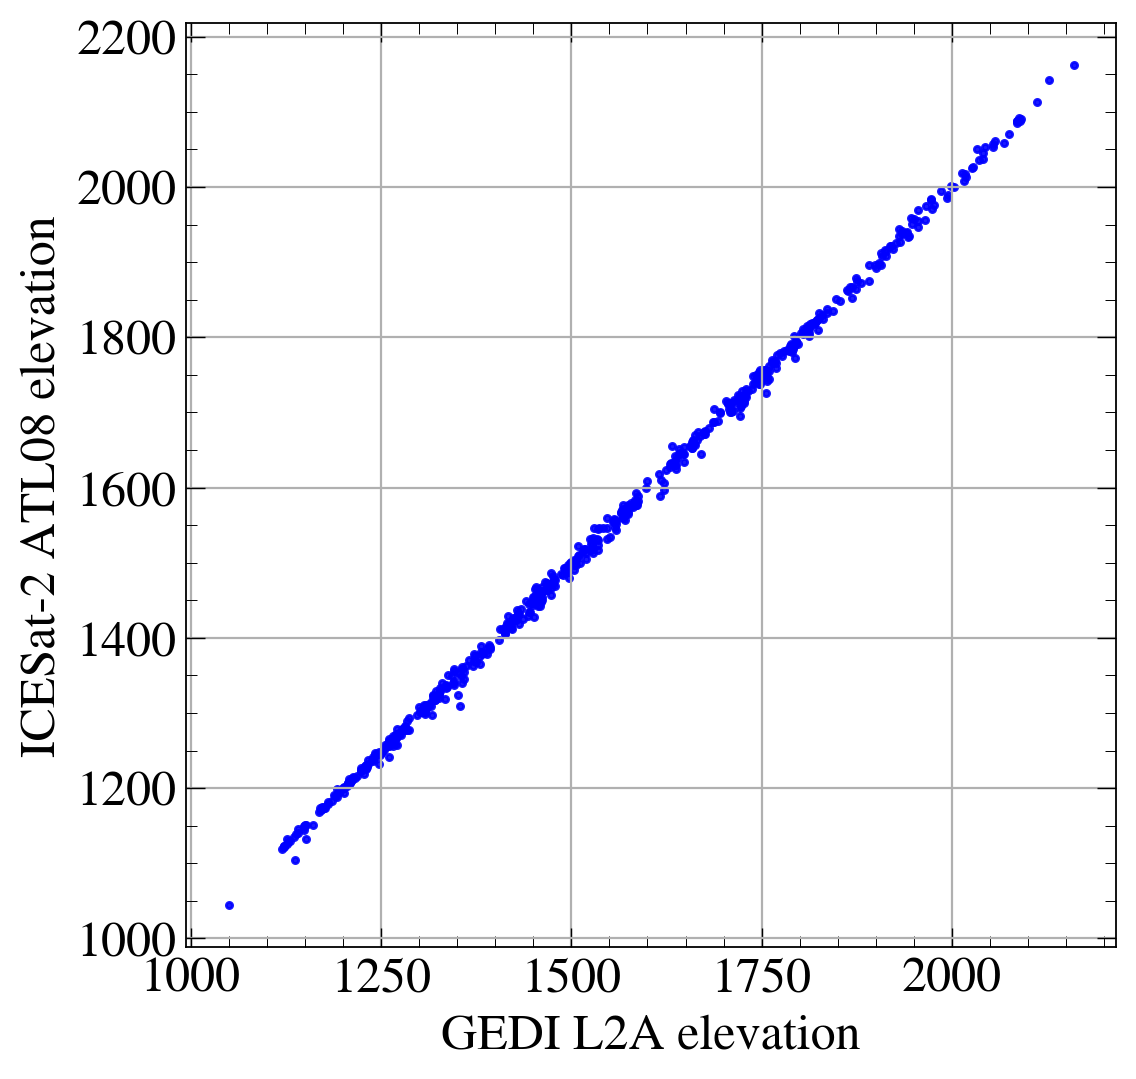

In [49]:
plt.scatter(coregistered_df["gedi_elevation"], coregistered_df["icesat2_elevation"], s=5, alpha=0.9, color="blue", label="GEDI (paired)")
# plt.title("GEDI vs ICESat-2 Elevations")# - Coregistered Footprints")
plt.xlabel('GEDI L2A elevation')
plt.ylabel('ICESat-2 ATL08 elevation')
plt.show()

### Plot Coregistered Points

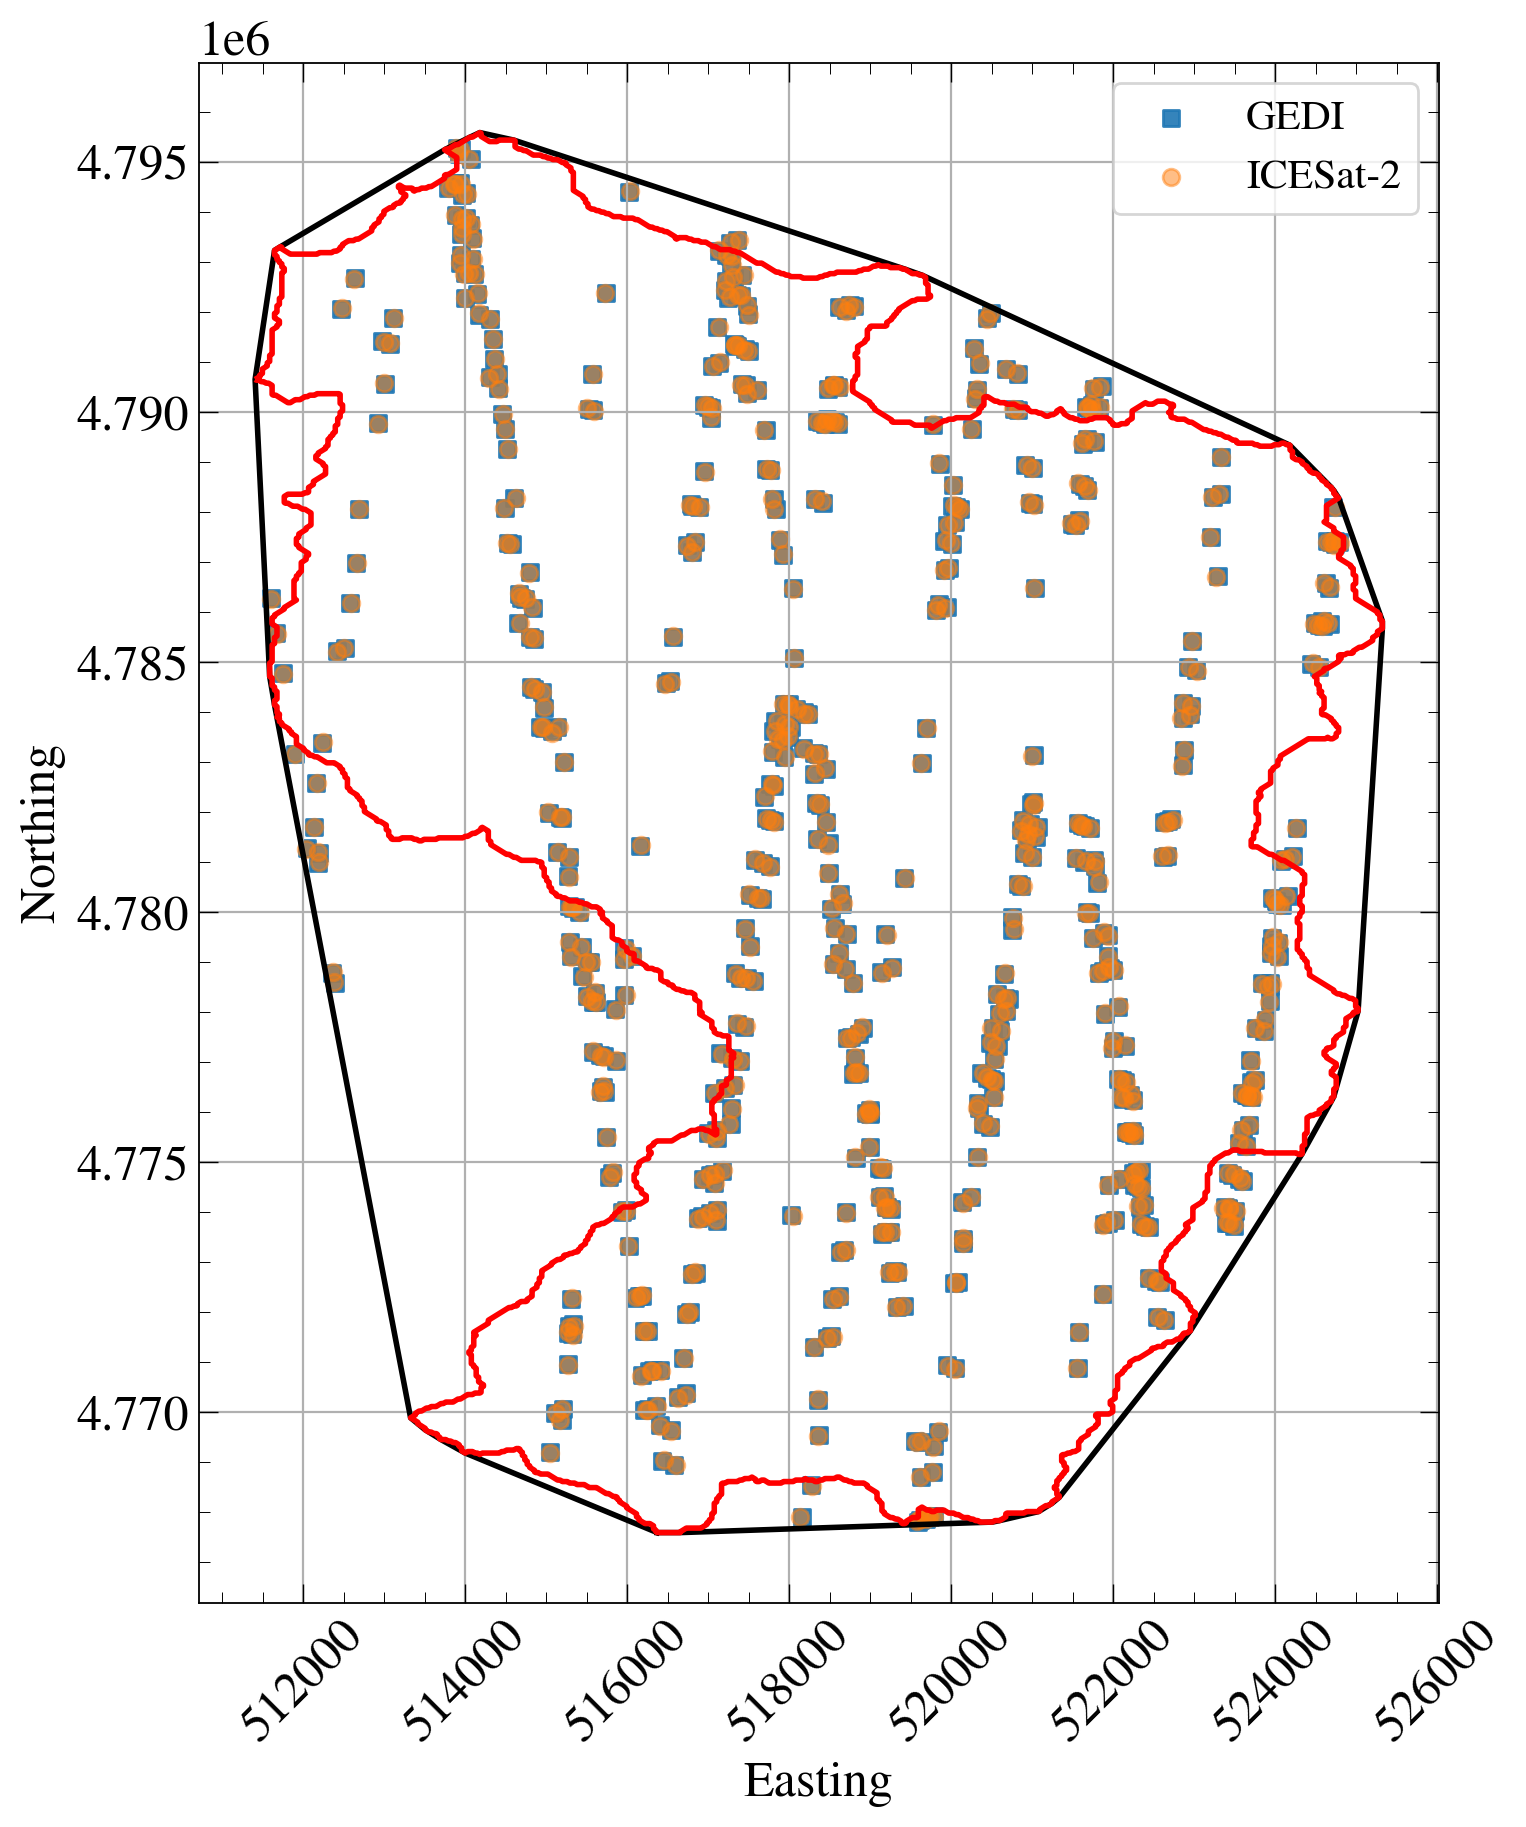

In [90]:
%matplotlib inline  

shp = "/bsuhome/tnde/geoscience/carbon_estimation/RCEW_shapefile_josh/RCEW_Boundary.shp"
# -------------------------------
# Read shapefile and match CRS
# -------------------------------
shapefile = gpd.read_file(shp)
# Reproject shapefile to raster CRS
shapefile = shapefile.to_crs("EPSG:6340")

# Plot grid cells
fig, ax = plt.subplots(figsize=(8, 10))
# fig, ax = plt.subplots(figsize=(20, 10))
# fig, ax = plt.subplots(figsize=(8, 10))
# ax.set_aspect('equal')

ax.scatter(coregistered_df['gedi_easting'], coregistered_df['gedi_northing'], label='GEDI', alpha=0.9, marker="s")
ax.scatter(coregistered_df['icesat2_easting'], coregistered_df['icesat2_northing'], label='ICESat-2', alpha=0.5, marker="o")

# Shapefile overlay 
ax.plot(region_lon, region_lat, linewidth=2.0, color='k')
shapefile.boundary.plot(ax=ax, edgecolor="red", linewidth=2.0)
ax.set_aspect('auto')

# Add a basemap (Optional)
# ctx.add_basemap(ax, crs=final_merged_gdf.crs, source=ctx.providers.Esri.WorldImagery)

# Add legend and labels
plt.legend(fontsize=15)
plt.xlabel("Easting")
plt.xticks(rotation=45)
plt.ylabel("Northing")
# plt.title("Coregistered GEDI and ICESat-2 Footprints")
plt.show()

In [52]:
coregistered_df['elevation_difference'] = coregistered_df['icesat2_elevation'] - coregistered_df['gedi_elevation']
len(coregistered_df['elevation_difference'])

590

## Vegetation Height Distribution

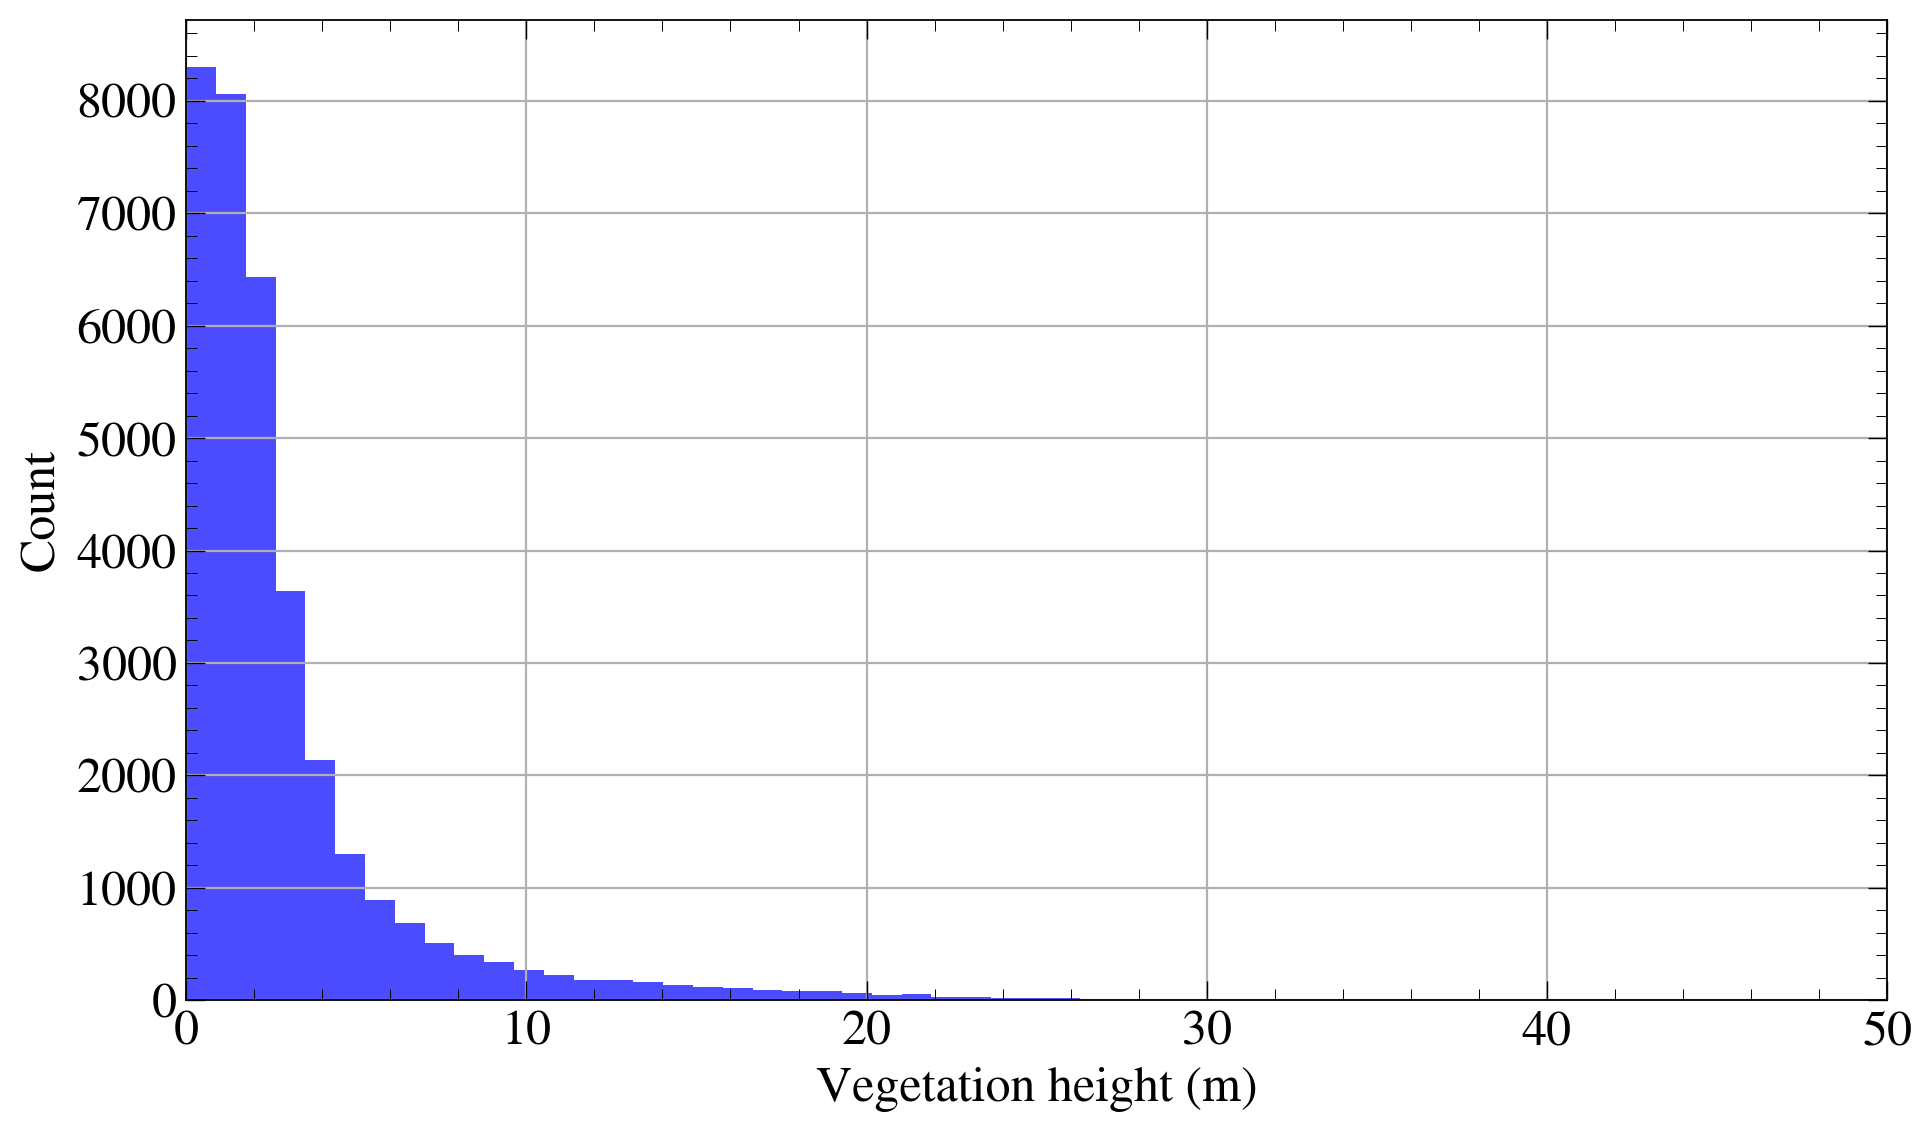

In [53]:
# ICESat-2 histogram
plt.figure(figsize=(10, 6))
plt.hist(icesat2_gdf_atl08['h_mean_canopy'], bins=150, color='blue', alpha=0.7)
plt.xlabel('Vegetation height (m)')
plt.ylabel('Count')
plt.xlim(0,50)
plt.tight_layout()
plt.show()

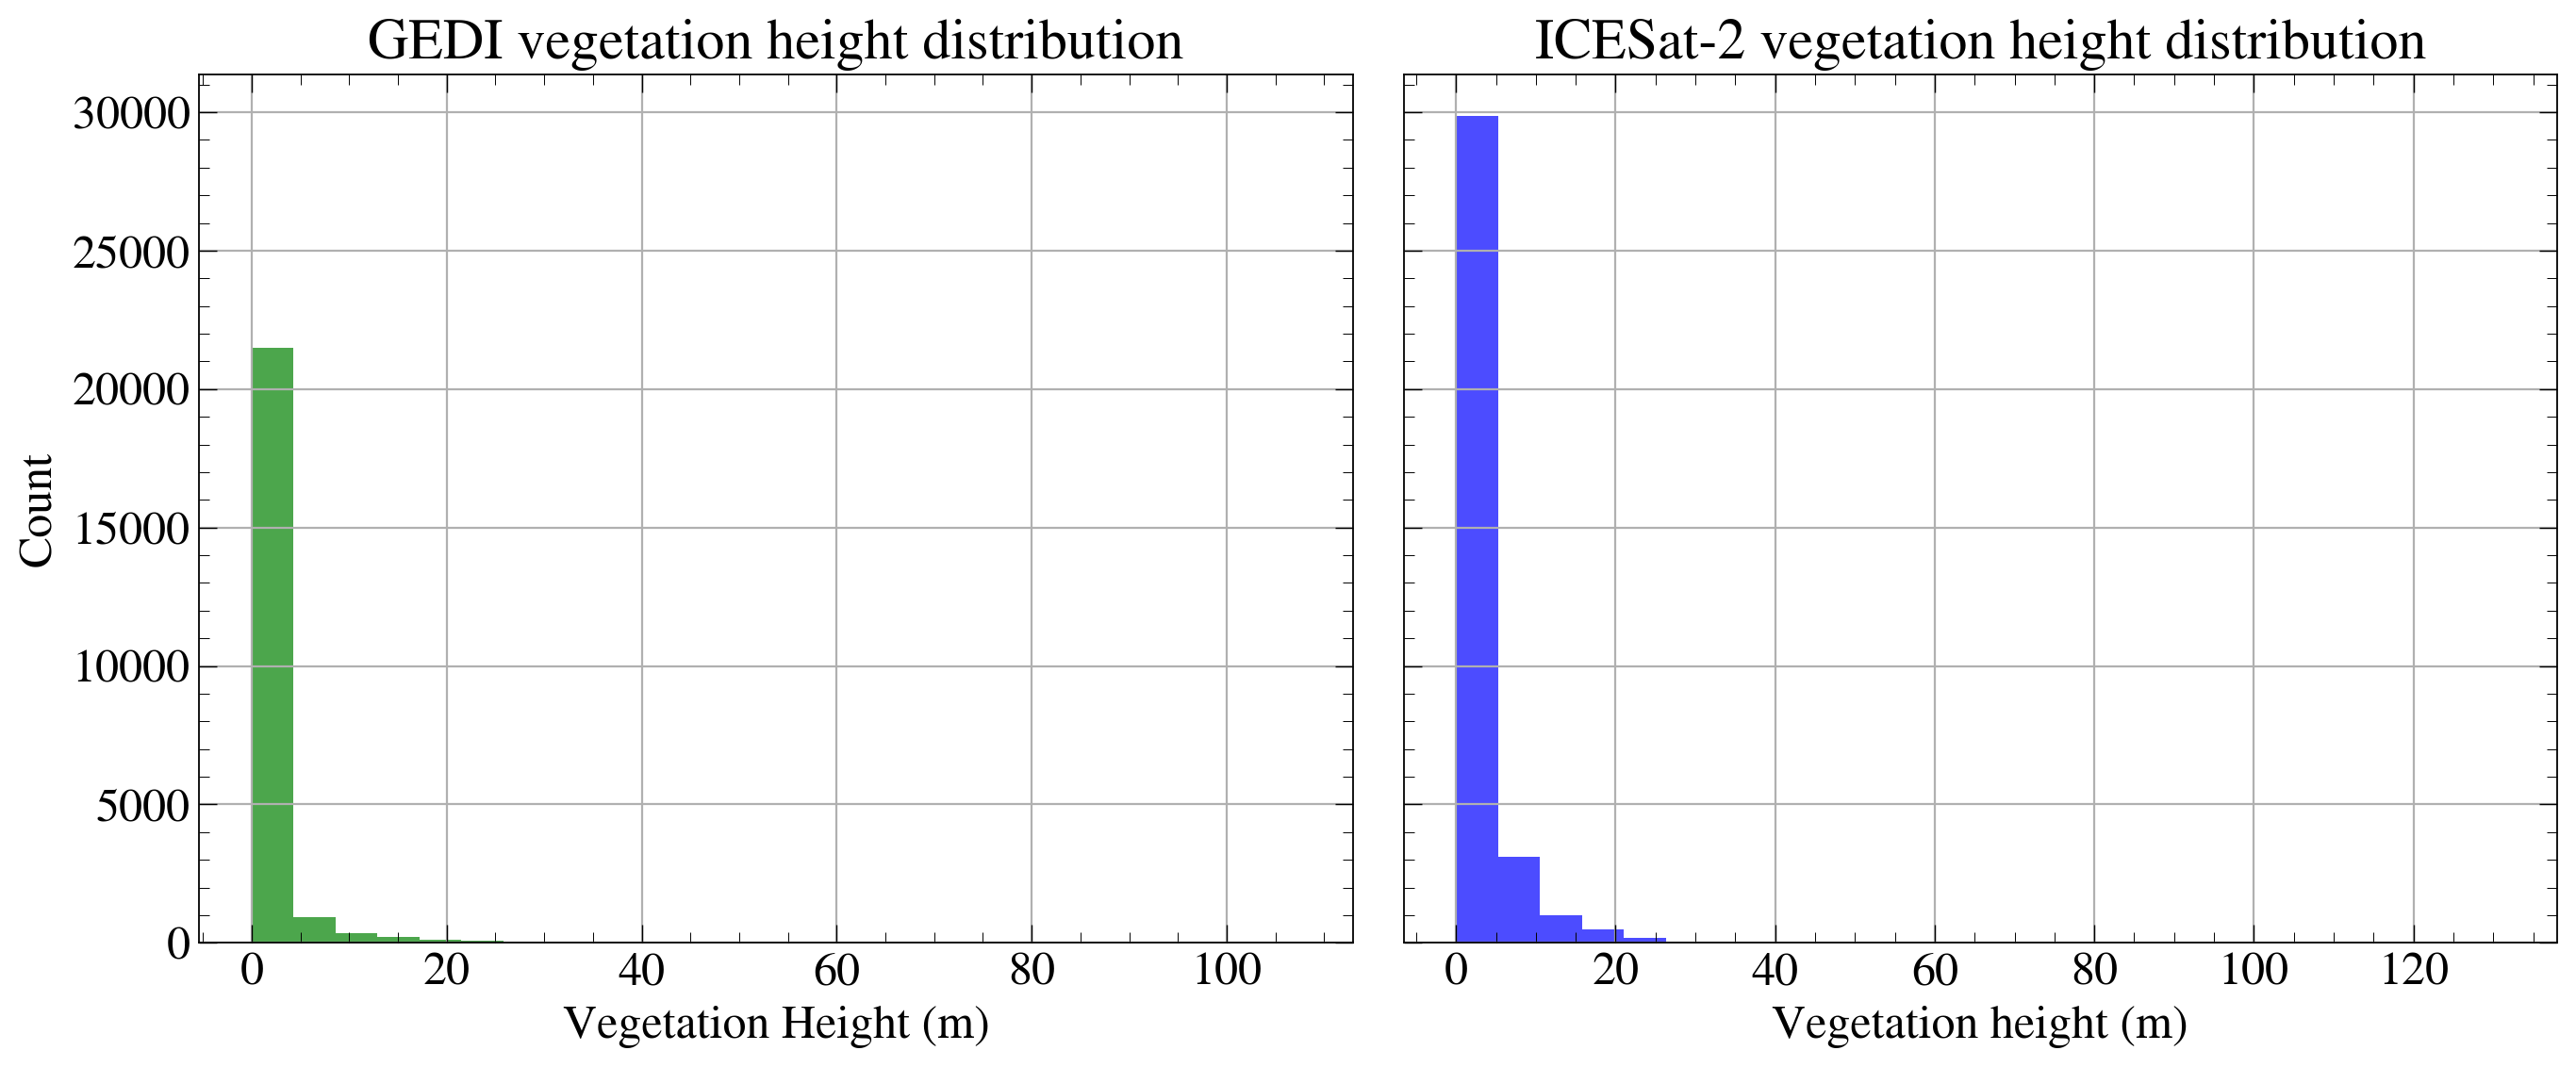

In [54]:
# Create subplots for GEDI and ICESat-2 histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# GEDI histogram
axes[0].hist(final_merged_gdf['rh_80'], bins=25, color='green', alpha=0.7)
axes[0].set_title('GEDI vegetation height distribution')
axes[0].set_xlabel('Vegetation Height (m)')
axes[0].set_ylabel('Count')

# ICESat-2 histogram
axes[1].hist(icesat2_gdf_atl08['h_mean_canopy'], bins=25, color='blue', alpha=0.7)
# axes[1].hist(vegetation_heights['vegetation_height'], bins=25, color='blue', alpha=0.7)
axes[1].set_title('ICESat-2 vegetation height distribution')
axes[1].set_xlabel('Vegetation height (m)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

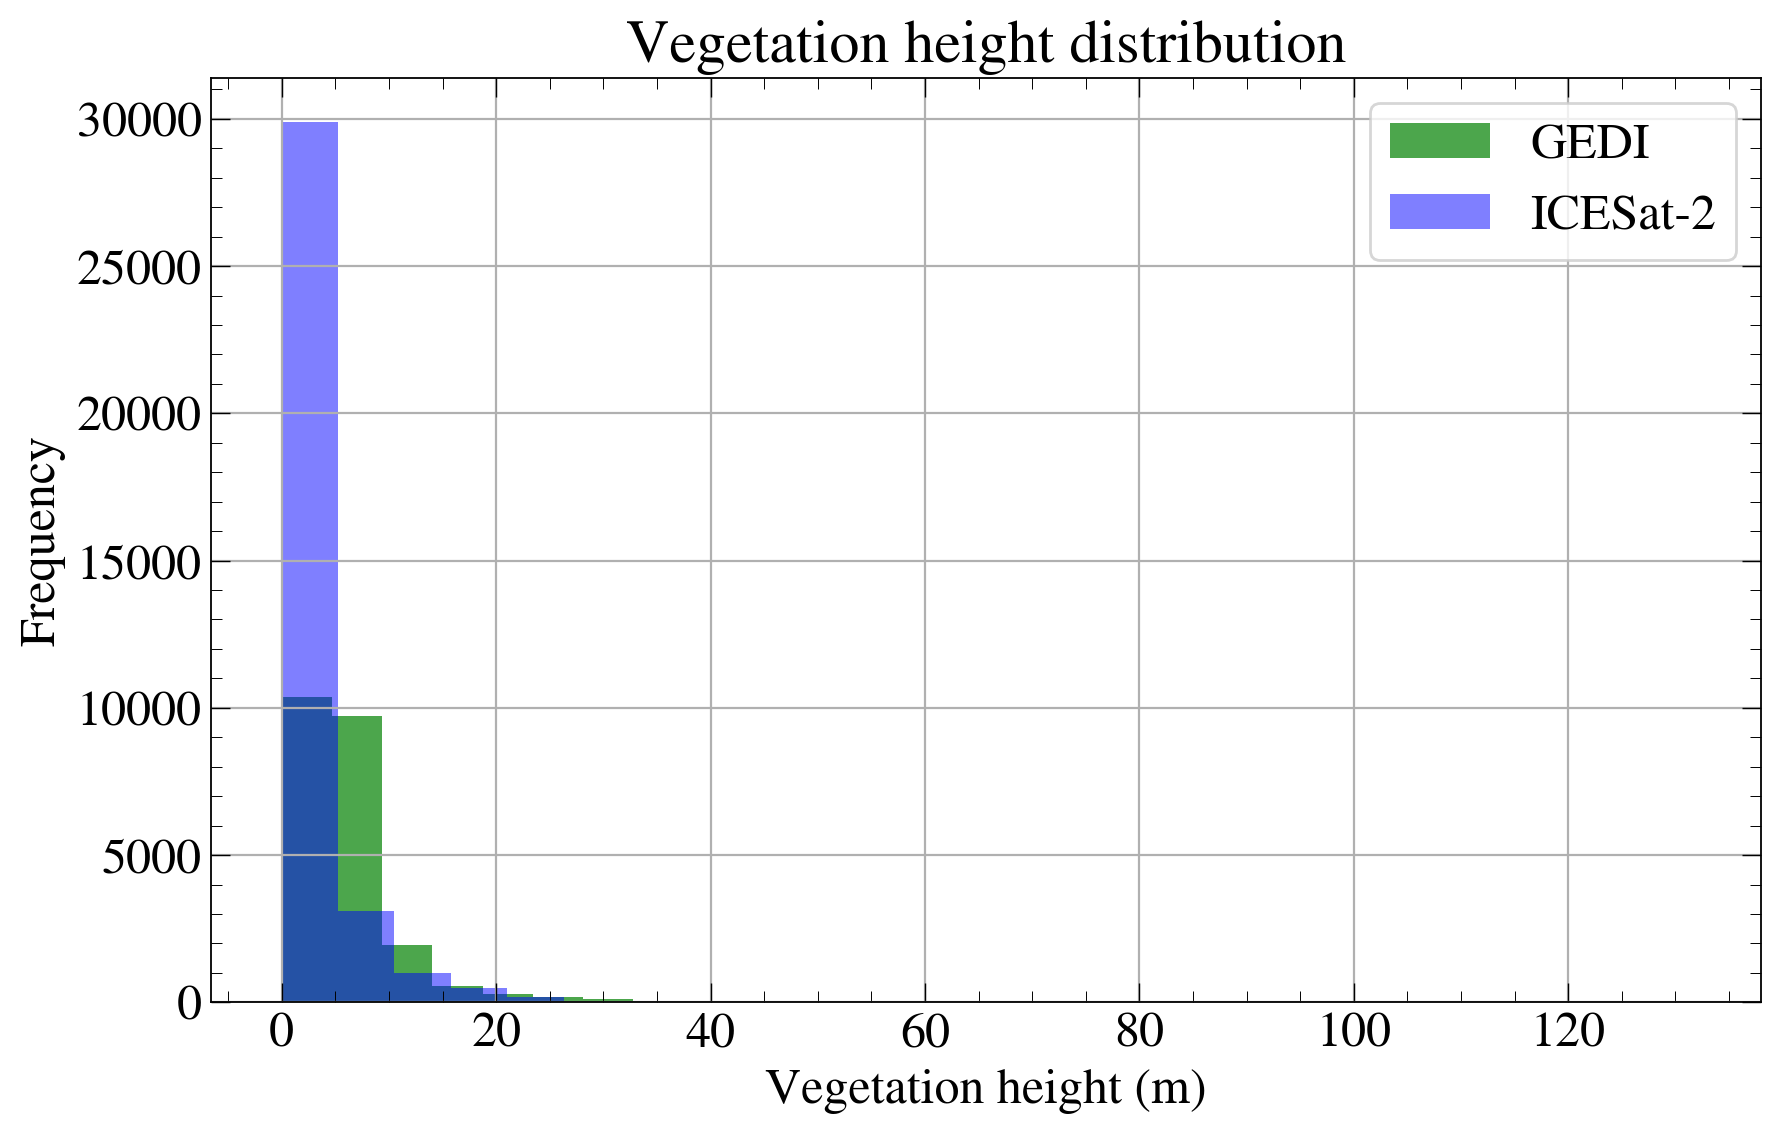

In [55]:
# Histogram of vegetation height for both GEDI and ICESat-2
plt.figure(figsize=(10, 6))

# GEDI histogram
final_merged_gdf['rh_100'].hist(bins=25, color='green', alpha=0.7, label='GEDI')

# ICESat-2 histogram
icesat2_gdf_atl08['h_mean_canopy'].hist(bins=25, color='blue', alpha=0.5, label='ICESat-2')

# Add title, labels, and legend
plt.title('Vegetation height distribution')
plt.xlabel('Vegetation height (m)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

## Loading ICESat-2 Data

### The ATL03 Product

In [22]:
from helper_functions import load_icesat2_data

# Projected CRS
projected_crs = "epsg:6340"   # Horizontal transformation: The EPSG code for NAD83/UTM zone 11N is 26911 (1983) or 6340 (2011).
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/"
# atl03 = icesat2_dir+f'{"rcew_icesat2_atl03_all_new_final2.geojson"}' 
atl03 = icesat2_dir+f'{"rcew_icesat2_atl03_vegheight.geojson"}' 
atl03

'/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_vegheight.geojson'

In [23]:
%%time
icesat2_gdf_atl03 = load_icesat2_data(atl03, "ATL03", process = False)
# icesat2_gdf_atl03 = icesat2_gdf_atl03.iloc[1:].reset_index(drop=True) # keep everything except the first row
print(icesat2_gdf_atl03.crs, "\n")

# outName = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_vegheight.geojson"
# icesat2_gdf_atl03.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

EPSG:6340 

CPU times: user 3min 41s, sys: 3.79 s, total: 3min 45s
Wall time: 3min 44s


In [24]:
from helper_functions import reduce_dataframe
# from sliderule import icesat2
# print(icesat2_gdf_atl03['rgt'].unique())
beam_type = 'strong'
project_crs = "EPSG:6430+EPSG:5703"
D3 = reduce_dataframe(icesat2_gdf_atl03, RGT=59, track=2, beam=beam_type, crs=project_crs)
# D3 = reduce_dataframe(icesat2_gdf_atl03, RGT=59, track=2, beam=beam_type) # RGT=501, 463, 905, 943, 1347, 59
D3.head()

time  pair           extent_id  region  sc_orient  \
1084258 2022-06-25 19:02:12.176     1  265713505443774465       6          1   
1084259 2022-06-25 19:02:12.176     1  265713505443774465       6          1   
1084260 2022-06-25 19:02:12.176     1  265713505443774465       6          1   
1084261 2022-06-25 19:02:12.176     1  265713505443774465       6          1   
1084262 2022-06-25 19:02:12.176     1  265713505443774465       6          1   

         track  solar_elevation  background_rate  cycle  segment_dist  \
1084258      2        67.827553     1.762595e+06     16  1.525185e+07   
1084259      2        67.827553     1.762595e+06     16  1.525185e+07   
1084260      2        67.827553     1.762595e+06     16  1.525185e+07   
1084261      2        67.827553     1.762595e+06     16  1.525185e+07   
1084262      2        67.827553     1.762595e+06     16  1.525185e+07   

         segment_id  rgt  atl08_class      x_atc     height  snowcover  \
1084258      761476   59            2 -51.901497  1082.2202          1   
1084259      761476   59            2 -51.201275  1080.8580          1   
1084260      761476   59            2 -51.185532  1083.3029          1   
1084261      761476   59            2 -50.489243  1081.7368          1   
1084262      761476   59            2 -50.473503  1084.2478          1   

           relief  yapc_score  quality_ph      y_atc  atl03_cnf  landcover  \
1084258  2.789795           0           0  32999.504          2         30   
1084259  1.059326           0           0  32999.602          2         30   
1084260  3.326050           0           0  32999.422          2         30   
1084261  1.249878           0           0  32999.531          2         30   
1084262  3.927246           0           0  32999.348          2         30   

         pce_mframe_cnt  h_dif_ref  spot   Longitude   Latitude  \
1084258       336928077   2.199219     3 -116.730525  43.272206   
1084259       336928077   2.199219     3 -116.730524  43.272199   
1084260       336928077   2.199219     3 -116.730526  43.272199   
1084261       336928077   2.199219     3 -116.730526  43.272193   
1084262       336928077   2.199219     3 -116.730528  43.272193   

               Easting      Northing  elevation_NAVD88_icesat2_from_pipe  \
1084258  521868.564563  4.791078e+06                         1099.162500   
1084259  521868.592341  4.791078e+06                         1097.800306   
1084260  521868.412691  4.791078e+06                         1100.245128   
1084261  521868.455483  4.791077e+06                         1098.679076   
1084262  521868.270965  4.791077e+06                         1101.190060   

         elevation_NAVD88_icesat2_from_crs                    Date  \
1084258                        1099.708442 2022-06-25 19:02:12.176   
1084259                        1098.346248 2022-06-25 19:02:12.176   
1084260                        1100.791069 2022-06-25 19:02:12.176   
1084261                        1099.225018 2022-06-25 19:02:12.176   
1084262                        1101.736002 2022-06-25 19:02:12.176   

                           date  ICESat2_slope_ratio_utm  \
1084258 2022-06-25 19:02:12.176                -0.107177   
1084259 2022-06-25 19:02:12.176                -1.932337   
1084260 2022-06-25 19:02:12.176                13.608071   
1084261 2022-06-25 19:02:12.176                -2.219370   
1084262 2022-06-25 19:02:12.176                13.607638   

         ICESat2_slope_degrees_utm  ICESat2_slope_rise_run  \
1084258                  -6.117419              -62.638068   
1084259                 -62.638068               85.797128   
1084260                  85.797128              -65.744707   
1084261                 -65.744707               85.796995   
1084262                  85.796995              -63.295800   

                              geometry  
1084258   POINT (12801.804 2625082.25)  
1084259  POINT (12801.595 2625079.943)  
1084260   POINT (12801.01 2625080.025)  
1084261   POIN

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
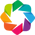

:Overlay
   .Scatter.Noise        :Scatter   [x]   (y)
   .Scatter.Unclassified :Scatter   [x]   (y)
   .Scatter.Canopy       :Scatter   [x]   (y)
   .Scatter.Canopy_top   :Scatter   [x]   (y)
   .Scatter.Ground       :Scatter   [x]   (y)

In [59]:
gv.extension('bokeh', 'matplotlib')
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
colors={0:['black', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']
        }
d0=np.min(D3['segment_dist'])

plt.figure(figsize=[14,5])

vis_list = []
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    vis_name = color_name[1]+'Vis'
    vis_name = hv.Scatter((D3['segment_dist'][ii]+D3['x_atc'][ii]-d0, D3['height'][ii]), label=color_name[1])
    vis_name = vis_name.opts(color=color_name[0], height=500, width=800, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5)
    vis_list.append(vis_name)

# Combine all three scatterplots
# (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(show_legend=True, 
#                                                                            legend_position='top_left',fontsize={'title':14, 'xlabel':16, 'ylabel': 16}, 
#                                                                            title=f'ICESat-2 Photon Classification',
#                                                                            tools=['hover'], xlabel=r"$x_{ATC}$ (m)", ylabel='height (m)')
    
# Plot Digital Elevation Model
hv.extension('bokeh')
# Assuming vis_list contains HoloViews elements
composite_plot = (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(
    show_legend=True,
    legend_position='bottom_right', #bottom_right
    fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16},
    title='ICESat-2 Photon Classification',
    tools=['hover'],
    # xlabel=r"$x_{ATC}$ (m)",
    xlabel=r"x_atc (m)", #x_atc: along track distance of the photon in meters (with respect to the center of the segment)
    ylabel='elevation (m)'
)

composite_plot

## Compute ATL03 segment vegetation height

In [32]:
# Make a copy so we don't accidentally modify the original
df = icesat2_gdf_atl03.copy()

# Extract date from the 'time' column and store it in a new 'Date' column
# This works whether 'time' is string or already datetime
df["Date"] = pd.to_datetime(df["time"]).dt.date   # or .dt.strftime("%Y-%m-%d") if you prefer strings

# Group by Date and segment_id, then compute mean relief
grouped = (
    df
    .groupby(["Date", "segment_id"], as_index=False)["relief"]
    .mean()
    .rename(columns={"relief": "mean_relief"})
)

result_df = grouped
result_df["mean_relief"] = result_df["mean_relief"].abs()
display(result_df)

Date  segment_id  mean_relief
0      2019-05-01      761971     0.413269
1      2019-05-01      761976     0.619181
2      2019-05-01      761981     3.602474
3      2019-05-01      761986     3.577361
4      2019-05-01      761991     0.990818
...           ...         ...          ...
15680  2024-10-19      762751     0.332006
15681  2024-10-19      762756     1.218782
15682  2024-10-19      762761     0.781110
15683  2024-10-19      762766     0.570644
15684  2024-10-19      762771     0.086798

[15685 rows x 3 columns]

In [34]:
# Make sure Date formats are consistent (string YYYY-MM-DD or datetime)
icesat2_gdf_atl08_merge = icesat2_gdf_atl08.copy()
result_df2 = result_df.copy()

icesat2_gdf_atl08_merge["Date"] = pd.to_datetime(icesat2_gdf_atl08_merge["time"]).dt.strftime("%Y-%m-%d")
result_df2["Date"] = pd.to_datetime(result_df2["Date"]).dt.strftime("%Y-%m-%d")

# Outer merge with indicator to see where each row came from
merged_outer = icesat2_gdf_atl08_merge.merge(
    result_df2,
    on=["Date", "segment_id"],
    how="outer",
    indicator=True
)

# All rows that did NOT successfully merge on both sides
not_merged = merged_outer[merged_outer["_merge"] != "both"]

# If you want to see which side they came from:
only_in_atl08  = merged_outer[merged_outer["_merge"] == "left_only"]   # in icesat2_gdf_atl08 only
only_in_result = merged_outer[merged_outer["_merge"] == "right_only"]  # in result_df only
merged_both = merged_outer[merged_outer["_merge"] == "both"]  # in both
merged_both = merged_both.dropna(subset=["mean_relief"])

# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl03_segment_footprint_veg_height_mean_relief.csv" #set name of the output #set name of the output
# merged_both.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# merged_both.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

In [35]:
merged_both
# icesat2_gdf_atl08

time       x_atc  h_min_canopy  h_te_median    gt  \
1     2019-05-01 02:00:18.808  15261861.0      0.620728    1673.5652  10.0   
2     2019-05-01 02:00:18.821  15261956.0      1.001221    1687.0344  10.0   
4     2019-05-01 02:00:18.837  15262066.0      1.146484    1718.3307  10.0   
6     2019-05-01 02:00:18.849  15262149.0      0.557983    1720.0553  10.0   
8     2019-05-01 02:00:18.864  15262262.0      0.520020    1719.2477  10.0   
...                       ...         ...           ...          ...   ...   
34854 2024-10-19 02:34:50.781  15277405.0      0.516846    2052.8770  50.0   
34856 2024-10-19 02:34:50.794  15277497.0      0.512207    2061.1707  50.0   
34858 2024-10-19 02:34:50.808  15277597.0      0.507568    2069.0027  50.0   
34860 2024-10-19 02:34:50.822  15277695.0      0.507568    2075.4067  50.0   
34862 2024-10-19 02:34:50.830  15277754.0      0.506104    2079.4434  50.0   

       spot    rgt  gnd_ph_count  h_mean_canopy   h_canopy  h_max_canopy  \
1       1.0  501.0          40.0       1.759356   5.692627      5.692627   
2       1.0  501.0           6.0       4.087218  15.897949     15.897949   
4       1.0  501.0           7.0       4.224749   8.523682      8.523682   
6       1.0  501.0          21.0       1.534317   3.273193      3.273193   
8       1.0  501.0          42.0       1.283726   3.224731      5.289429   
...     ...    ...           ...            ...        ...           ...   
34854   5.0  501.0         158.0       1.969527   8.566406      8.566406   
34856   5.0  501.0          75.0       2.170150   8.770264      8.770264   
34858   5.0  501.0          98.0       1.626314   4.192627      4.192627   
34860   5.0  501.0         100.0       1.301732   3.288818      3.288818   
34862   5.0  501.0          35.0       0.679639   0.873535      0.873535   

       snowcover  ph_count                                   canopy_h_metrics  \
1            1.0      54.0  (1.6063232421875, 1.6063232421875, 1.606323242...   
2            1.0      45.0  (1.82666015625, 1.82666015625, 1.82666015625, ...   
4            1.0      43.0  (1.983642578125, 1.983642578125, 1.98364257812...   
6            1.0      54.0  (1.5433349609375, 1.5433349609375, 1.543334960...   
8            1.0      92.0  (1.395263671875, 1.395263671875, 1.39526367187...   
...          ...       ...                                                ...   
34854        1.0     191.0  (1.23193359375, 1.23193359375, 1.23193359375, ...   
34856        1.0     167.0  (1.501220703125, 1.501220703125, 1.50122070312...   
34858        1.0     182.0  (1.488525390625, 1.488525390625, 1.48852539062...   
34860        1.0     176.0  (1.479736328125, 1.479736328125, 1.47973632812...   
34862        1.0      40.0  (0.87353515625, 0.87353515625, 0.87353515625, ...   

       solar_elevation_x  segment_id  veg_ph_count  landcover     extent_id  \
1               7.485723      761976          14.0       30.0  2.256304e+18   
2               7.485555      761981          39.0       30.0  2.256304e+18   
4               7.485390      761986          36.0       30.0  2.256304e+18   
6               7.485191      761991          33.0       30.0  2.256304e+18   
8               7.485056      761996          50.0       30.0  2.256304e+18   
...                  ...         ...           ...        ...           ...   
34854         -18.305649      762751          33.0       30.0  2.256305e+18   
34856         -18.305658      762756          92.0       30.0  2.256305e+18   
34858         -18.305664      762761          84.0       30.0  2.256305e+18   
34860         -18.305664      762766          76.0       30.0  2.256305e+18   
34862         -18.305666      762771           5.0       30.0  2.256305e+18   

       canopy_openness  cycle  num_bins  binsize  \
1             1.201639    3.0       6.0      1.0   
2             4.197688    3.0      15.0      1.0   
4             2.087010    3.0       8.0      1.0   
6             0.800312    3.0       3.0      

In [36]:
# Option 1
veg_opt1 = compute_segment_veg_height1(icesat2_gdf_atl03, method="option1")

# Option 2
veg_opt2 = compute_segment_veg_height1(
    icesat2_gdf_atl03,
    atl08_gdf=icesat2_gdf_atl08.drop(columns=["Date"]),
    method="option2"
)

In [40]:
# Outer merge with indicator to see where each row came from
merged_outer = icesat2_gdf_atl08_merge.merge(
    veg_opt1,
    on=["Date", "segment_id"],
    how="outer",
    indicator=True
)

merged_both = merged_outer[merged_outer["_merge"] == "both"]  # in both
merged_both = merged_both.dropna(subset=["vegetation_height"])

# cvs_name = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/ml_data/atl03_segment_footprint_veg_height_option2.csv" #set name of the output #set name of the output
# merged_both.to_csv(cvs_name)

# outName = cvs_name.replace(".csv", ".geojson")  # Create an output file name using the input file name
# merged_both.to_file(outName, driver="GeoJSON")  # Export to GeoJSON

In [42]:
corr = merged_both[["h_mean_canopy", "vegetation_height"]].corr()
print(corr)

                   h_mean_canopy  vegetation_height
h_mean_canopy           1.000000           0.001093
vegetation_height       0.001093           1.000000


In [124]:
veg_opt2.head(20)

Date  segment_id  vegetation_height
0   2019-05-01      761976           4.826464
1   2019-05-01      761981           7.138015
2   2019-05-01      761986           1.316147
3   2019-05-01      761991           1.184330
4   2019-05-01      761996           1.765298
5   2019-05-01      762001           1.057971
6   2019-05-01      762006           5.015856
7   2019-05-01      762011           3.672569
8   2019-05-01      762016           5.646764
9   2019-05-01      762021        1819.565318
10  2019-05-01      762026        1824.868750
11  2019-05-01      762031          16.812333
12  2019-05-01      762036        1750.051869
13  2019-05-01      762056        1691.445600
14  2019-05-01      762066           3.286612
15  2019-05-01      762071           1.388806
16  2019-05-01      762076           1.307300
17  2019-05-01      762081           3.153145
18  2019-05-01      762086           0.428205
19  2019-05-01      762091           0.273545

In [117]:
icesat2_gdf_atl08[["time", "segment_id", "h_te_median", "h_mean_canopy"]].head(20)

time  segment_id  h_te_median  h_mean_canopy
0  2019-05-01 02:00:18.808      761976    1673.5652       1.759356
1  2019-05-01 02:00:18.821      761981    1687.0344       4.087218
2  2019-05-01 02:00:18.837      761986    1718.3307       4.224749
3  2019-05-01 02:00:18.849      761991    1720.0553       1.534317
4  2019-05-01 02:00:18.864      761996    1719.2477       1.283726
5  2019-05-01 02:00:18.879      762001    1727.2041       1.773410
6  2019-05-01 02:00:18.892      762006    1738.3242       2.299464
7  2019-05-01 02:00:18.906      762011    1760.8872       2.097279
8  2019-05-01 02:00:18.920      762016    1777.7363       2.786242
9  2019-05-01 02:00:18.937      762021       0.0000       4.407859
10 2019-05-01 02:00:18.945      762026       0.0000       8.129700
11 2019-05-01 02:00:18.967      762031    1745.4285       4.666321
12 2019-05-01 02:00:18.972      762036       0.0000      16.246723
13 2019-05-01 02:00:19.036      762056       0.0000       4.012939
14 2019-05-01 02:00:19.062      762066    1677.4711       1.397293
15 2019-05-01 02:00:19.075      762071    1672.3220       1.226074
16 2019-05-01 02:00:19.090      762076    1667.3353       1.227973
17 2019-05-01 02:00:19.104      762081    1661.1716       1.950262
18 2019-05-01 02:00:19.118      762086    1657.9597       1.315326
19 2019-05-01 02:00:19.133      762091    1648.6051       1.974585

## The End